# Minigrid environment

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
from gym_minigrid import minigrid_env
import numpy as np
import cv2
import random
import seaborn as sns
sns.set_theme(style="darkgrid")

pygame 2.5.1 (SDL 2.28.2, Python 3.8.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext autoreload

In [3]:
env = minigrid_env.Env(size=15, agent_view_size=5,num_tiles=50)
observation, info = env.reset(seed=42)

In [4]:
%autoreload 2

(-0.5, 479.5, 479.5, -0.5)

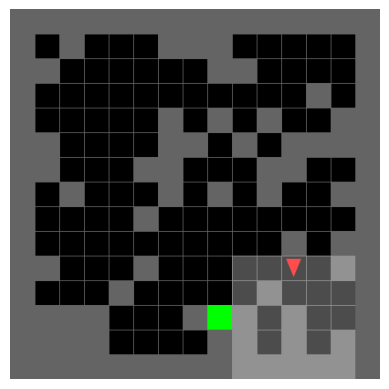

In [6]:
_ = env.reset(seed=123)
plt.imshow(env.get_frame())
plt.axis('off')

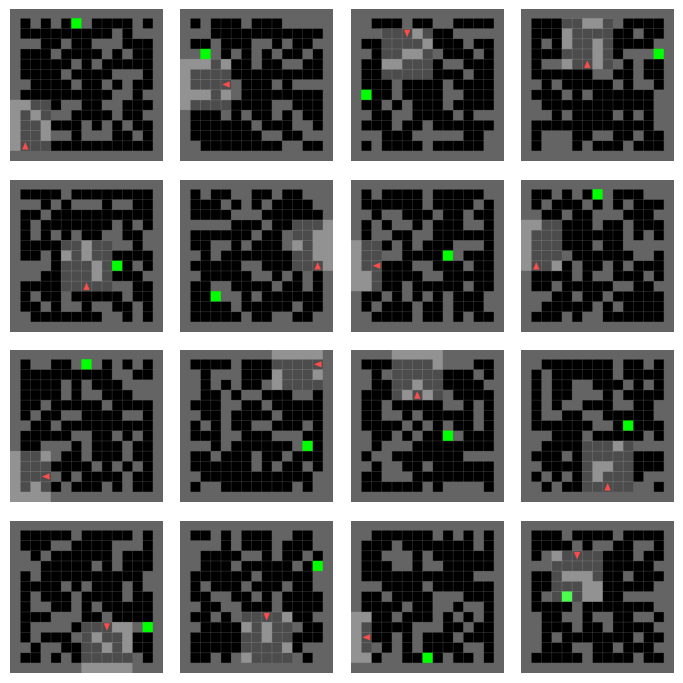

In [7]:
plt.figure(figsize=(7,7))

# Draw 16 environments
for i in range(16):
    plt.subplot(4, 4, i+1)
    _ = env.reset(seed=i)
    plt.imshow(env.get_frame())
    plt.axis('off')

plt.tight_layout()
plt.show()

Generate random grids

In [ ]:
grids = []
pos = []
num_grids = 50_000

# Generate a bunch of random grids
for i in range(num_grids):
    env.reset(seed=i)
    grids.append(env.get_full_render(highlight=False, tile_size=1))
    pos.append((env.agent_pos, env.goal_pos))

    print(f"Generated {i+1}/{num_grids} grids", end="\r")

grids = np.array(grids)

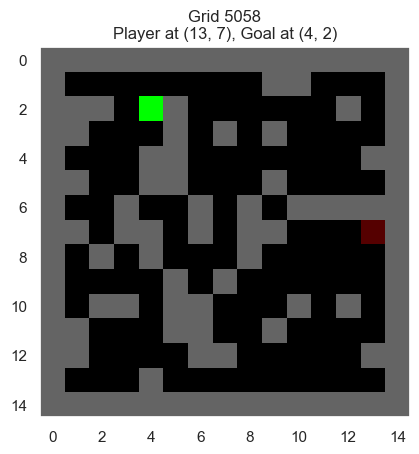

In [532]:
i = random.randint(0, num_grids-1)

plt.imshow(grids[i])
plt.title(f"Grid {i}\nPlayer at {pos[i][0]}, Goal at {pos[i][1]}")
plt.grid(False)
plt.show()

_______

Create dataset

In [8]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class GridsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, grids, pos):
        self.grids = grids
        self.pos = pos

    def __len__(self):
        return len(self.grids)

    def __getitem__(self, index):
        x = TF.to_tensor(self.grids[index])
        y = torch.tensor(self.pos[index])
        return x, y

In [534]:
X = grids

Y = np.array(pos).astype(np.float32)
# Reshape to (num_samples, 4)
Y = Y.reshape(Y.shape[0], -1)
# Set center to 0,0 and scale to [-1, 1]
Y -= 7
Y /= 7

In [596]:
# Save the data
np.save("grids.npy", X)
np.save("pos.npy", Y)

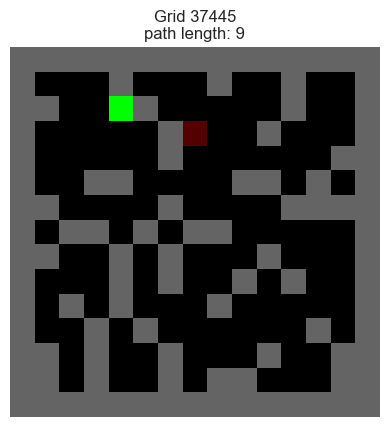

In [597]:
i = random.randint(0, len(X)-1)
path_length = path_lengths[i]
plt.imshow(X[i])
plt.axis('off')
plt.title(f"Grid {i}\npath length: {path_length}")
plt.grid(False)
plt.show()

In [9]:
# Load the data
X = np.load("grids.npy")
Y = np.load("pos.npy")

In [10]:
X.shape, Y.shape

((50000, 15, 15, 3), (50000, 4))

In [11]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Create datasets
train_dataset = GridsDataset(X_train, Y_train)
val_dataset = GridsDataset(X_val, Y_val)

Train model

In [12]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=7*7*64):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 24, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 48, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(mu.device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [15]:
import torch
import torch.nn as nn

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=7*7*64):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32, vec_dim=4):
        super(VAE, self).__init__()
        self.image_channels = image_channels
        self.vec_dim = vec_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 24, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten()
        )

        self.fc1 = nn.Linear(h_dim + vec_dim, z_dim)
        self.fc2 = nn.Linear(h_dim + vec_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 48, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )

        # Additional output layer for the vector
        self.fc4 = nn.Linear(z_dim, vec_dim)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = mu + std * eps
        return z

    def bottleneck(self, h, v):
        combined = torch.cat((h, v), dim=1)
        mu, logvar = self.fc1(combined), self.fc2(combined)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x, v):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h, v)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x, v):
        z, mu, logvar = self.encode(x, v)
        reconstructed_image = self.decode(z)
        output_vector = self.fc4(z)
        return reconstructed_image, output_vector, mu, logvar

In [16]:
# Loss for VAE with image output
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

# Loss for VAE with image + vector output
def loss_function(recon_x_image, recon_vector, x_image, x_vector, mu, logvar):
    # Reconstruction losses
    BCE_image = F.binary_cross_entropy(recon_x_image, x_image, reduction='sum')
    MSE_vector = F.mse_loss(recon_vector, x_vector, reduction='sum')

    # Kullback-Leibler divergence
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = BCE_image + MSE_vector + KLD

    return total_loss

def train_vae(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4, early_stopping={'patience': 5, 'min_delta': 0.001}):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = {'train_loss': [], 'val_loss': []}
    early_stop_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training
        for x_image, x_vector in train_loader:
            optimizer.zero_grad()

            x_image = x_image.to(device)
            x_vector = x_vector.to(device)

            x_image_hat, x_vector_hat, mu, logvar = model(x_image, x_vector)

            loss = loss_function(x_image_hat, x_vector_hat, x_image, x_vector, mu, logvar)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_image, x_vector in val_loader:

                x_image = x_image.to(device)
                x_vector = x_vector.to(device)

                x_image_hat, x_vector_hat, mu, logvar = model(x_image, x_vector)

                loss = loss_function(x_image_hat, x_vector_hat, x_image, x_vector, mu, logvar)

                val_loss += loss.item()
        val_loss /= len(val_loader.dataset)

        average_loss = total_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch + 1}/{num_epochs}], train_loss: {average_loss:.4f}, val_loss: {val_loss:.4f}')

        loss_history['train_loss'].append(average_loss)
        loss_history['val_loss'].append(val_loss)

        # Early stopping
        if epoch > 0:
            if loss_history['val_loss'][-1] < best_val_loss - early_stopping['min_delta']:
                best_val_loss = loss_history['val_loss'][-1]
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= early_stopping['patience']:
                print('Early stopping.')
                break

    print('Training finished.')

    return loss_history

In [606]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

image_channels = 3
latent_dim = 64
hidden_dim = 64 * 7 * 7
vec_dim = 4

vae_model = VAE(image_channels=image_channels, z_dim=latent_dim, h_dim=hidden_dim, vec_dim=vec_dim).to(device)

batch_size = 16
num_epochs = 500
early_stopping = {'patience': 15, 'min_delta': 0.05}

# Data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train VAE
loss_history = train_vae(vae_model,
                        train_loader,
                        val_loader,
                        num_epochs=num_epochs,
                        learning_rate=1e-4,
                        early_stopping=early_stopping)

Device: cuda
Epoch [1/500], train_loss: 300.1283, val_loss: 293.5128
Epoch [2/500], train_loss: 285.2673, val_loss: 274.1319
Epoch [3/500], train_loss: 264.1236, val_loss: 258.1428
Epoch [4/500], train_loss: 256.0447, val_loss: 254.6644
Epoch [5/500], train_loss: 253.0933, val_loss: 252.1365
Epoch [6/500], train_loss: 250.3790, val_loss: 249.2523
Epoch [7/500], train_loss: 247.3700, val_loss: 246.3263
Epoch [8/500], train_loss: 244.2662, val_loss: 243.1509
Epoch [9/500], train_loss: 241.5854, val_loss: 241.0356
Epoch [10/500], train_loss: 239.7034, val_loss: 239.5759
Epoch [11/500], train_loss: 238.3974, val_loss: 238.4097
Epoch [12/500], train_loss: 237.2659, val_loss: 237.1478
Epoch [13/500], train_loss: 236.2074, val_loss: 236.1582
Epoch [14/500], train_loss: 235.1016, val_loss: 235.0713
Epoch [15/500], train_loss: 234.0584, val_loss: 234.2099
Epoch [16/500], train_loss: 233.1218, val_loss: 232.9178
Epoch [17/500], train_loss: 232.1835, val_loss: 232.0285
Epoch [18/500], train_loss:

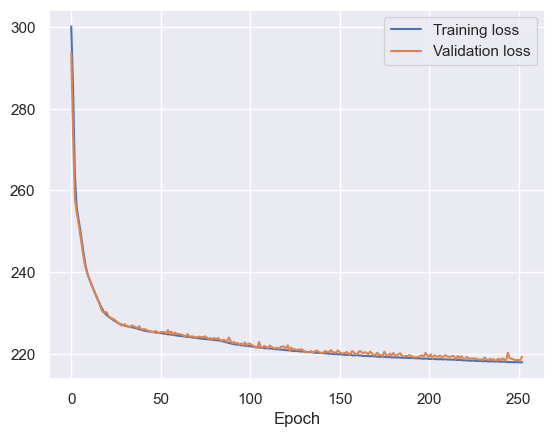

In [607]:
# Plot training and validation loss
plt.plot(loss_history['train_loss'], label="Training loss")
plt.plot(loss_history['val_loss'], label="Validation loss")
plt.xlabel("Epoch")
plt.legend()
# plt.ylim(20,50)

In [608]:
# Save VAE model
torch.save(vae_model.state_dict(), f"VAE_MiniGrid_latent-dim-{latent_dim}.pt")

In [18]:
# Load VAE model
vae_model = VAE(image_channels=3, z_dim=latent_dim, h_dim=hidden_dim, vec_dim=vec_dim).to(device) # GPU
vae_model.load_state_dict(torch.load(f"VAE_MiniGrid_latent-dim-{latent_dim}.pt"))

<All keys matched successfully>

Plot reconstructed grids

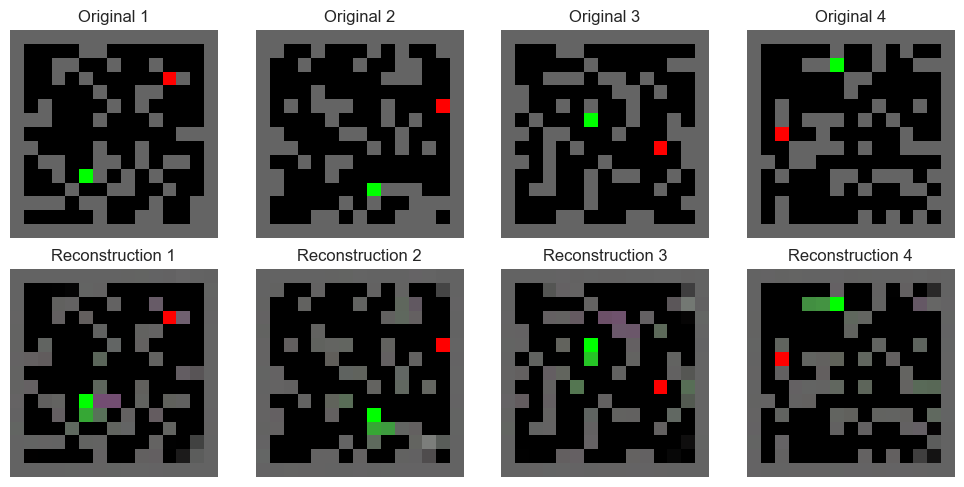

In [19]:
# Plot reconstruction

n_images = 4

plt.figure(figsize=(10, 5))

for i in range(n_images):
    j = np.random.randint(0, X_val.shape[0])
    x = val_dataset[j][0].unsqueeze(0).to(device)
    y = val_dataset[j][1].unsqueeze(0).to(device)
    recon_x, recon_y, _, _ = vae_model(x, y)
    recon_x = recon_x.to('cpu').detach().numpy().squeeze()
    recon_x = np.moveaxis(recon_x, 0, -1)
    recon_y = recon_y.to('cpu').detach().numpy().squeeze()*7 + 7  # Scale back to original coordinates
    recon_y = recon_y.astype(int)

    y = y.to('cpu').detach().numpy().squeeze()*7 + 7  # Scale back to original coordinates
    y = y.astype(int)

    x = x.to('cpu').detach().numpy().squeeze()
    x = np.moveaxis(x, 0, -1)

    # Add player and goal to image
    x[y[1], y[0]] = [1, 0, 0]  # Player
    x[y[3], y[2]] = [0, 1, 0]  # Goal
    recon_x[recon_y[1], recon_y[0]] = [1, 0, 0]  # Player
    recon_x[recon_y[3], recon_y[2]] = [0, 1, 0]  # Goal

    plt.subplot(2,4,i+1)
    
    plt.imshow(x)
    plt.axis('off')
    plt.title(f"Original {i+1}")

    plt.subplot(2,4,i+5)
    plt.imshow(recon_x)
    plt.axis('off')
    plt.title(f"Reconstruction {i+1}")

plt.tight_layout()

Path finding algorithm

In [455]:
from pathfinding.core.diagonal_movement import DiagonalMovement
from pathfinding.core.grid import Grid
from pathfinding.finder.a_star import AStarFinder
from pathfinding.finder.breadth_first import BreadthFirstFinder

def replace_char(char):
    if char == '+' or char == '-' or char == '|' or char == '#':
        return [125, 125, 125]
    elif char == 's':
        return [255, 0, 0]
    elif char == 'e':
        return [0, 255, 0]
    elif char == 'x':
        return [0, 0, 255]
    else:
        return [0, 0, 0]

def get_shortest_path(grid, pos):
    """Get the shortest path from the start to the end

    Args:
    grid (np.array): 2D grid where 0 is free space and 1 is obstacle
    pos (tuple): Start and end position in the grid (start_x, start_y, end_x, end_y)
    """
    start, end = pos[:2], pos[2:]
    maze = np.abs(grid - 1)

    # Ensure start and end are free
    #maze[start[0], start[1]] = 1
    #maze[end[0], end[1]] = 1
    
    grid = Grid(matrix=maze)
    start = grid.node(start[0], start[1])
    end = grid.node(end[0], end[1])
    
    finder = AStarFinder(diagonal_movement=DiagonalMovement.never)
    path, runs = finder.find_path(start, end, grid)

    return path

In [592]:
idx = random.randint(0, len(X)-1)
idx = i

maze = np.ceil(X[idx]/255).mean(axis=-1).astype(int)
positions = np.round(Y[idx]*7 + 7).astype(int)
maze[positions[1], positions[0]] = 0
maze[positions[3], positions[2]] = 0

path = get_shortest_path(maze, positions)
path = [(p.y, p.x) for p in path]

Path length: 14


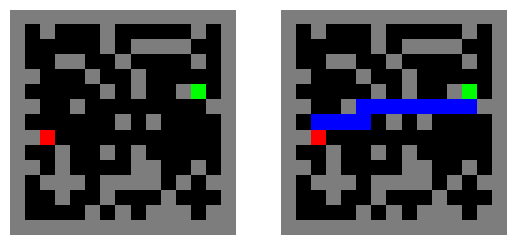

In [593]:
# Replace start and end
maze = (np.stack([maze]*3, axis=-1) * 125).astype(np.int16)
maze[positions[1], positions[0]] = [255, 0, 0]
maze[positions[3], positions[2]] = [0, 255, 0]

plt.subplot(121)
plt.imshow(maze)
plt.grid(False)
plt.axis('off')

plt.subplot(122)
# Replace path
for p in path[1:-1]:
    maze[p[0], p[1]] = [0, 0, 255]

plt.imshow(maze)
plt.grid(False)
plt.axis('off')

print("Path length:", len(path))

Calculate path length of all grids

In [582]:
path_lengths = []

for i in range(X.shape[0]):
    maze = np.ceil(X[i]/255).mean(axis=-1).astype(int)
    positions = np.round(Y[i]*7 + 7).astype(int)
    maze[positions[1], positions[0]] = 0
    maze[positions[3], positions[2]] = 0

    path = get_shortest_path(maze, positions)

    path_lengths.append(len(path))
    
    print(f"Processed {i+1}/{X.shape[0]}", end="\r")

path_lengths = np.array(path_lengths)

In [594]:
np.save("path_lengths.npy", path_lengths)

Text(0, 0.5, 'Frequency')

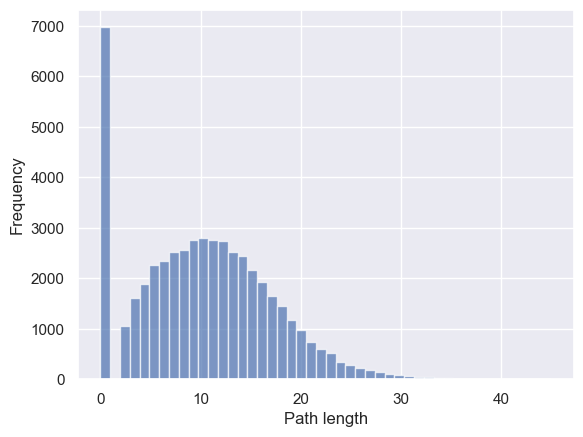

In [586]:
hist = plt.hist(path_lengths, bins=46, alpha=0.7)
plt.xlabel("Path length")
plt.ylabel("Frequency")

In [514]:
zero_length_idxs = np.where(path_lengths == 0)[0]

Text(0.5, 1.0, 'Grid 25182')

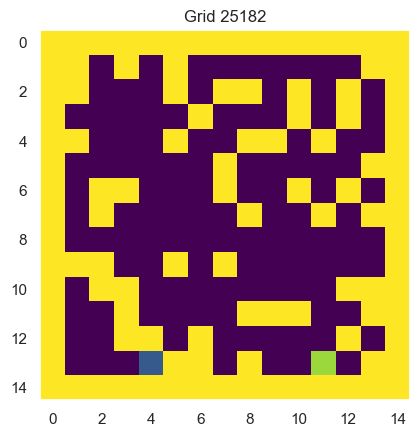

In [517]:
idx = np.random.choice(zero_length_idxs)

plt.imshow(X[idx, ..., 0], cmap='viridis')
plt.grid(False)
plt.title(f"Grid {idx}")